# Radial Prediction Layer - German Traffic Sign - Dataset (GTSDB)
### Basis ist das Projekt: pyt_rpl_mnist.jpynb
### Angepasst und ergänzt für Verkehrszeichen (j.h, 2019-10-13)

- [Imports](#Imports)
- [Configuration](#Configuration)
- [Data](#MNIST-Data) 
- [Create and Train Networks](#Create-and-Train-Networks)
- [Compare Softmax and RPL](#Compare-Softmax-and-RPL-Predictions)
- [Adversarial Examples](#Adversarial-Examples)

# Quellen
### Basisprogramm
https://gitlab.com/peroyose/radial_prediction_layers

### The German Traffic Sign Detection Benchmark:
http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

### Load the GTSRB train dataset
https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

### Load the GTSRB test dataset
https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip

### Transfer Learning in PyTorch: How to Use DataLoaders and Build a Fully Connected Clas
https://blogs.oracle.com/datascience/transfer-learning-in-pytorch%2c-part-1%3a-how-to-use-dataloaders-and-build-a-fully-connected-class

## Imports

In [1]:
from __future__ import print_function
import time
from tabulate import tabulate
''' https://de.wikipedia.org/wiki/PyTorch  (torch - Fackel)
PyTorch ist eine auf Maschinelles Lernen ausgerichtete Open-Source-Programmbibliothek
für die Programmiersprache Python, basierend auf der in Lua geschriebenen Bibliothek Torch.
[2][3][4] Entwickelt wurde PyTorch von dem Facebook-Forschungsteam für künstliche Intelligenz.[5][6][7] (j.h)'''
## Videotutorial: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html (j.h) ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#? from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
#? from torch.utils.data import DataLoader 
#? from torch._six import int_classes as _int_classes

'''Das torchvision-Paket besteht aus gängigen Datensätzen, Modellarchitekturen und
allgemeinen Bildtransformationen für die Bildverarbeitung.'''
import torchvision
from   torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image   ## ~~~~~
import random           ##+

### Module der Verfasser (HTW) --> Unterverzeichnis ./rpl/pytorch/ ###
from rpl.pytorch.rpl import RadialPredictionLayer, RadialPredictionLoss
from rpl.pytorch.adverserial_attack import run_attack
from rpl.pytorch.utils import predict_probabilities
from rpl.pytorch.utils import print_learnable_params
'''j.h Module  from path.file import class'''
## from _module.loadDatatsets import PerCsv  ## entfällt
torch.manual_seed(40)
np.random.seed(40)

# The following two lines are for reloading any imported files if they are modified while 
## our Jupyter Notebook is running
## %load_ext autoreload
## %autoreload 2

## Configuration
Define some configuration parameters for the notebook run:
 - `verbose`: If True, additional informations will be printed
 - `save_fig`: If True, all ploted figures will be saved in './pics'
 - `class_num`: Number of classes in the dataset
 - `batch_size`: Mini-batch size used for the data loaders

In [2]:
verbose = True
save_fig = True
class_num = 43 
batch_size = 2**2
epochs = 10
'''Bildformat wite * hohe (j.h)'''
weite=28
hoehe=28
farbkanaele=3

## Berechnungen werden auf GPU ausgeführt wenn möglich ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Methoden
- split_image_data: Teilt Datenmengen

In [3]:
'''Teilt ein oder auch zwei Datenmengen in drei Datenmengen auf und erzeugt entsprechende Datenlader
- Hinweis: Wird hier nicht verwendet.
@ train_data  - Trainingsdatenmenge
@ test_date   - Testdatenmenge, optional
@ batch_size  - Batchgröße, Paketgröße
@ num_workers - 
@ valid_size  - Aufteilung, 0.2 bedeutet: 0.6 Training-, 0.2 Test-, 0.2 Validierung-sdaten
@ sampler     - Auswahlverfahren
@ RETURN
@ train_loader - Trainingsdatenlader
@ valid_loader - Validierungsdatenlader 
@ test_loader  - Testdatenlader
'''
def split_image_data(train_data,
                     test_data=None,
                     batch_size=20,
                     num_workers=0,
                     valid_size=0.2,
                     sampler=SubsetRandomSampler):
    
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = sampler(train_idx)
    valid_sampler = sampler(valid_idx)
    if test_data is not None:
        test_loader = DataLoader(test_data, batch_size=batch_size,
        num_workers=num_workers)
    else:
        train_idx, test_idx = train_idx[split:],train_idx[:split]
        train_sampler = sampler(train_idx)
        test_sampler = sampler(test_idx)
        
        test_loader = torch.utils.data.DataLoader(train_data, 
                                                  batch_size=batch_size,
                                                  sampler=test_sampler,
                                                  num_workers=num_workers)

    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=num_workers)
    
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size, 
                                               sampler=valid_sampler,
                                               num_workers=num_workers)
    
    return train_loader,valid_loader,test_loader

''' ------------------------------------------------------------------------------
Ermittelt Mittelwert und Dtandardabweichung eines Datensetz zur
nachfolgenden Optimierung der Eingangsbilder
@ dataset - Datenset (Bilder)
RETURN:
@ imgs_mean - Mittelwert aller Intensitätswerte
@ imgs_std  - Standardabweichung aller Pixel um den Mittelwert, Maß der Streuung
'''
def calculate_img_stats_full(dataset):
    imgs_ = torch.stack([img for img,_ in dataset],dim=3)
    imgs_ = imgs_.view(3,-1)
    imgs_mean = imgs_.mean(dim=1)
    imgs_std = imgs_.std(dim=1)
    return imgs_mean,imgs_std


## GTS-Dataset

Load the GTSRB train and test dataset
https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip


In [4]:
#j.h# Load GTS train and test data  -->  wird von torchvision.datasets nicht unterstützt (j.h) 
## torchvision.transforms.functional.to_grayscale(img, num_output_channels=1) ##

train_data_path="./dataTraining/"
test_data_path="./dataTest/"
''' ## Farbbild  to Graubild 
transforms=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(size=(weite,hoehe),interpolation=2),
                               transforms.ToTensor(),                               
                                print("train_mean, train_std", train_mean, train_std)transforms.Normalize(mean=[0.5],std=[0.2])]) '''
'''transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)'''


''' Farbbild mit drei kanaelen '''
train_transforms=transforms.Compose([transforms.Resize(size=(weite,hoehe),interpolation=2), 
                                    #transforms.RandomHorizontalFlip(),
                                    #transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    # transforms.Normalize(mean=[0.3309,0.3022,0.3113],std=[0.2747,0.2604,0.266]),      
                                    ])

test_transforms=transforms.Compose([transforms.Resize(size=(weite,hoehe),interpolation=2),
                                    transforms.ToTensor(),
                                    # transforms.Normalize(mean=[0.361,0.3204,0.3362],std=[0.2675,0.2526,0.2617]),
                                    ])
                             
                               

gts_train_data        =torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transforms)
gts_test_data         = torchvision.datasets.ImageFolder(root=test_data_path, transform=test_transforms)
gts_test_data_adv_att = torchvision.datasets.ImageFolder(root=test_data_path, transform=test_transforms)

# Ermittelt Mittelwert und Standarabweichung der Datensets
train_mean, train_std= calculate_img_stats_full(gts_train_data)    
test_mean, test_std= calculate_img_stats_full(gts_test_data) 

train_loader        = torch.utils.data.DataLoader(gts_train_data, batch_size=batch_size, shuffle=True)
test_loader         = torch.utils.data.DataLoader(gts_test_data, batch_size=batch_size)
test_loader_adv_att = torch.utils.data.DataLoader(gts_test_data, batch_size=1)



if  verbose:
    print("train_mean, train_std", train_mean, train_std)
    print("test_mean, test_std", test_mean, test_std)
    print("\n")
    print("DataLoader are initialized with a gts-batch size of {}.".format(batch_size))
    print("\n")
    print("gts_train_data: \n",gts_train_data) ## for Test
    print("gts_train_data[200]: \n",gts_train_data[1]) ## for Test
    print("\n")
    print("gts_test_data: \n",gts_test_data) ## for Test
    print("gts_test_data[200]: \n",gts_test_data[1]) ## for Test
    

train_mean, train_std tensor([0.3422, 0.3131, 0.3220]) tensor([0.2725, 0.2592, 0.2646])
test_mean, test_std tensor([0.3619, 0.3212, 0.3368]) tensor([0.2674, 0.2527, 0.2617])


DataLoader are initialized with a gts-batch size of 4.


gts_train_data: 
 Dataset ImageFolder
    Number of datapoints: 26640
    Root location: ./dataTraining/
gts_train_data[200]: 
 (tensor([[[0.2745, 0.2980, 0.3020,  ..., 0.3216, 0.2824, 0.2588],
         [0.2588, 0.2980, 0.3412,  ..., 0.3843, 0.3020, 0.2667],
         [0.2510, 0.2824, 0.3451,  ..., 0.4510, 0.3020, 0.2745],
         ...,
         [0.6667, 0.6157, 0.5804,  ..., 0.2980, 0.3020, 0.3373],
         [0.4392, 0.4353, 0.4157,  ..., 0.3059, 0.3451, 0.4039],
         [0.2980, 0.3373, 0.3490,  ..., 0.2863, 0.3804, 0.3961]],

        [[0.2902, 0.3098, 0.3059,  ..., 0.3294, 0.3059, 0.2706],
         [0.2745, 0.2980, 0.3294,  ..., 0.3412, 0.3137, 0.2745],
         [0.2667, 0.2863, 0.3176,  ..., 0.3412, 0.3020, 0.2824],
         ...,
         [0.5490, 0.537

# Hinweise, Ergebnisse
### Normalisierung der Bilder 
transforms.Normalize(mean=[0.361,0.3204,0.3362],std=[0.2675,0.2526,0.2617])
- Die Normalisierung hat keine Verbesserung bewirkt. Das Ergebnis ist, trotz Berechnung der optimalen Mittelwerte und Standardabweichungen, etwas schlechter geworden.


## Create and Train Networks

In [5]:
"""
Simple convoilutional neural network using softmax or RPL as classifier
"""
class RadialPredictionNet_GTS(nn.Module):
    ''' Konstruktor
    Args:
    num_classes (int): Number of classes in the dataset
    use_rpl (bool): Used classification layer --> True=RPL or False=log_softmax
    '''
    def __init__(self, num_classes, use_rpl=True):    
        super(RadialPredictionNet_GTS, self).__init__()
        self.use_rpl = use_rpl
        self.conv1 = nn.Conv2d(farbkanaele, 10, kernel_size=5)   # 3 - Eingabekanäle r,g,b, 10 - 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.rpl = RadialPredictionLayer(num_classes, num_classes)        

    ## MODEL FOR RPL AND SOFTMAX ##
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)         
        if self.use_rpl:
            return self.rpl(x)
        return F.log_softmax(x, dim=1)

    
    def probabilities(self, x, beta=1.0):
        out = self.forward(x)
        return torch.exp(beta * out)

    
def train_gts(model, data, optimizer, criterion, epochs=10):
    print('Starting training...\n')   
    since = time.time()
    for e in range(epochs):
        # Initialize log vars
        loss_sum = 0
        correct_preds = 0
        accuracy = 0
        
        for mini_batch in data:
            # Move batch to device
            x, y  = mini_batch[0], mini_batch[1]
            x = x.to(device)
            y = y.to(device)
            
            # Clean buffer
            optimizer.zero_grad() 
            
            # Calculate output and loss
            output = model.forward(x)
            loss = criterion(output, y)
            
            # Backprop and optimze
            loss.backward()
            optimizer.step()
                
            # Accumulate batch loss and number of correct classified samples 
            loss_sum += loss
            correct_preds += (y == output.argmax(dim=1)).sum()
        
        epoch_loss = loss_sum/len(data)
        accuracy = correct_preds.item()/len(data.dataset)
        print("E[{}] || Loss: {:4f} || Correct Classified: {} || Accuracy: {:4f}".format(e, epoch_loss, correct_preds, accuracy))
    
    time_elapsed = time.time() - since
    print("\n...training finished in {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))      
    return model      

### Initialize Networks

In [6]:
# Initialize networks with RPL and softmax as classifierppmNormImage
model_rpl = RadialPredictionNet_GTS(class_num, use_rpl=True)
model_softmax = RadialPredictionNet_GTS(class_num, use_rpl=False)

if verbose:
    print("Prototypes:", model_rpl.rpl.prototypes)
    print_learnable_params(model_rpl)
    print_learnable_params(model_softmax)

Prototypes: Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Following parameters of the model will be updated:
- conv1.weight
- conv1.bias
- conv2.weight
- conv2.bias
- fc1.weight
- fc1.bias
- fc2.weight
- fc2.bias
- fc3.weight
- fc3.bias

Following parameters of the model will be updated:
- conv1.weight
- conv1.bias
- conv2.weight
- conv2.bias
- fc1.weight
- fc1.bias
- fc2.weight
- fc2.bias
- fc3.weight
- fc3.bias


### Train RPL Network

In [7]:
# Put model into train mode and move it to device
model_rpl.train()
model_rpl.to(device)

# Initialize optimizer and loss function
optimizer_rpl = optim.Adam(model_rpl.parameters(), lr=0.0001)
loss_rpl = RadialPredictionLoss()

# Train model
model_rpl = train_gts(model_rpl, train_loader, optimizer_rpl, loss_rpl, epochs=epochs)

Starting training...

E[0] || Loss: 0.855829 || Correct Classified: 9999 || Accuracy: 0.375338
E[1] || Loss: 0.652408 || Correct Classified: 16558 || Accuracy: 0.621547
E[2] || Loss: 0.542034 || Correct Classified: 19853 || Accuracy: 0.745233
E[3] || Loss: 0.466102 || Correct Classified: 22012 || Accuracy: 0.826276
E[4] || Loss: 0.407572 || Correct Classified: 23180 || Accuracy: 0.870120
E[5] || Loss: 0.356952 || Correct Classified: 23783 || Accuracy: 0.892755
E[6] || Loss: 0.318473 || Correct Classified: 24177 || Accuracy: 0.907545
E[7] || Loss: 0.288975 || Correct Classified: 24537 || Accuracy: 0.921059
E[8] || Loss: 0.264185 || Correct Classified: 24893 || Accuracy: 0.934422
E[9] || Loss: 0.243124 || Correct Classified: 25107 || Accuracy: 0.942455

...training finished in 8m 18s



### Train Softmax Network

In [8]:
# Put model into train mode and move it to device
model_softmax.train()
model_softmax.to(device)

# Initialize optimizer and loss function
optimizer_softmax = optim.Adam(model_softmax.parameters(), lr=0.0001)
loss_softmax = F.nll_loss

# Train model
model_softmax = train_gts(model_softmax, train_loader, optimizer_softmax, loss_softmax, epochs=epochs)  

Starting training...

E[0] || Loss: 3.045615 || Correct Classified: 4668 || Accuracy: 0.175225
E[1] || Loss: 1.860335 || Correct Classified: 12024 || Accuracy: 0.451351
E[2] || Loss: 1.109941 || Correct Classified: 17783 || Accuracy: 0.667530
E[3] || Loss: 0.751115 || Correct Classified: 20709 || Accuracy: 0.777365
E[4] || Loss: 0.551159 || Correct Classified: 22328 || Accuracy: 0.838138
E[5] || Loss: 0.419949 || Correct Classified: 23484 || Accuracy: 0.881532
E[6] || Loss: 0.327598 || Correct Classified: 24147 || Accuracy: 0.906419
E[7] || Loss: 0.266151 || Correct Classified: 24656 || Accuracy: 0.925526
E[8] || Loss: 0.216518 || Correct Classified: 25043 || Accuracy: 0.940053
E[9] || Loss: 0.183808 || Correct Classified: 25313 || Accuracy: 0.950188

...training finished in 4m 13s



## Compare Softmax and RPL Predictions

Plot correct and wrong predictions for both models. You are able to configure different `beta values` for the plots of the RPL network.

Soft:	Correct:687 || Wrong:167
RPL:	Correct:753 || Wrong:101


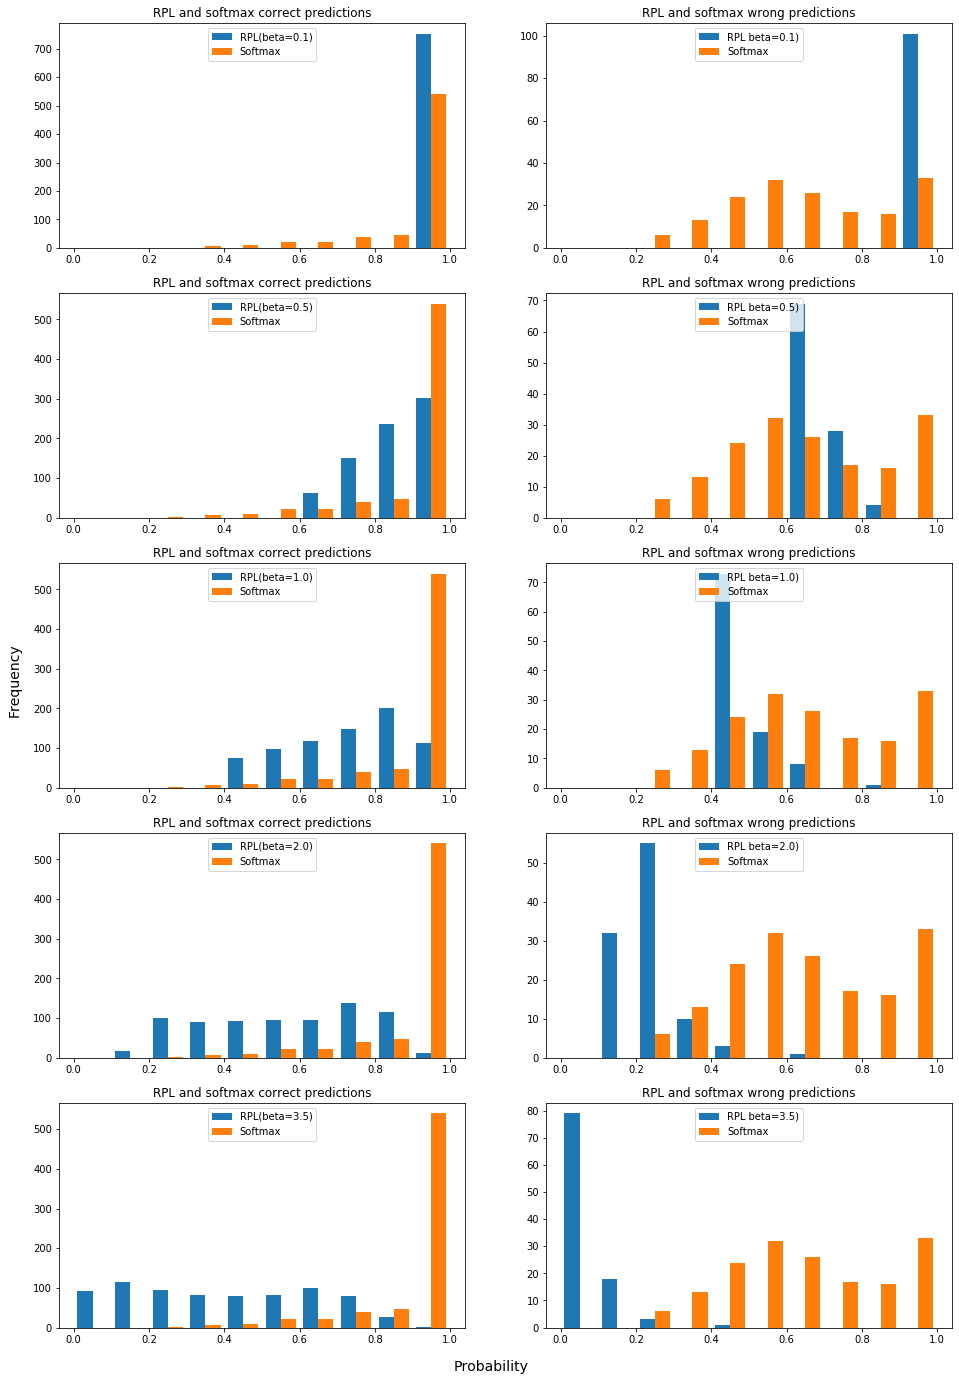

In [9]:
# Define which beta values to plot
beta_values = [0.1, 0.5, 1.0, 2.0, 3.5]
density= False

# Put the models into evaluation mode
model_rpl.eval()
model_softmax.eval()

# Plot config 
fig = plt.figure(figsize=(16, 24))
fig.text(0.5, 0.1, "Probability", ha="center", fontsize=14)
fig.text(0.08, 0.5, "Frequency", va="center", rotation="vertical",  fontsize=14)
bins = np.arange(0,1.1,0.1)
beta_len = len(beta_values)

# Predict test set for the softmax model
correct_probs_soft, wrong_probs_soft = predict_probabilities(model_softmax, 
                                                             test_loader, 
                                                             device=device
                                                            )
for idx in range(beta_len):
    # Predict test set with RPL model and a certain beta value
    correct_probs_rpl, wrong_probs_rpl = predict_probabilities(model_rpl, 
                                                               test_loader, 
                                                               beta_values[idx], 
                                                               device
                                                  
                                                              )
    
    # Create correct predictions plot
    plt.subplot(beta_len, 2, (2*idx)+1)
    plt.hist((correct_probs_rpl, correct_probs_soft), 
             density=density, 
             bins=bins, 
             label=("RPL(beta={})".format(str(beta_values[idx])), "Softmax")
            )
    plt.legend(loc="upper center")
    plt.title("RPL and softmax correct predictions")    
    
    # Create wrong predictions plot
    plt.subplot(beta_len, 2, (2*idx)+2)
    plt.hist((wrong_probs_rpl, wrong_probs_soft), 
             density=density, 
             bins=bins, 
             label=("RPL beta={})".format(str(beta_values[idx])),"Softmax")
            )
    plt.legend(loc="upper center")
    plt.title("RPL and softmax wrong predictions")

if verbose:     
    print("Soft:\tCorrect:{} || Wrong:{}".format(len(correct_probs_soft), len(wrong_probs_soft)))    
    print("RPL:\tCorrect:{} || Wrong:{}".format(len(correct_probs_rpl), len(wrong_probs_rpl)))
 
                 
if save_fig:
    plt.savefig("./pics/mnist_preds.png", bbox_inches="tight")

## Adversarial Examples

From here, both models will be explored on adversarial attacks - Fast Gradient Sign Attack (FGSM). 

### Run FGSM Attacks

In [10]:
# Define epsilon values to be testedfrom scipy.misc import toimage
epsilons = np.array([0, .02, .05, .1, .15, .2, .25, .3])

# Dicts for each model to run the attack and summarize the results
attack_rpl = {"name": "Radial Decision Layer",
              "model": model_rpl, 
              "criterion": loss_rpl,
              "beta": 2.0,
              "accuracies": [], 
              "examples": [], 
              "props": [], 
              "props_wrong": []
             }

attack_soft = {"name": "Softmax Classifier",
               "model": model_softmax, 
               "criterion": loss_softmax,
               "beta": 1.0,
               "accuracies": [], 
               "examples": [], 
               "props": [], 
               "props_wrong": []
              }

models = [attack_rpl, attack_soft]

# Run test for each epsilon on the RPL and softmax model
for model in models:
    print("Running FGSM attacks on {} ...\n ".format(model["name"]))
    
    for eps in epsilons:
        acc, example, p_mean, wp_mean = run_attack(model["model"], 
                                                   test_loader_adv_att, 
                                                   model["criterion"], 
                                                   eps,
                                                   model["beta"], 
                                                   device
                                                  )
        model["accuracies"].append(acc)
        model["examples"].append(example)
        model["props"].append(p_mean)
        model["props_wrong"].append(wp_mean)
        
        if verbose:
            print("Epsilon: {} \tAccuracy: {}".format(eps, acc))
    
    # Convert to numpy arrays
    model["accuracies"] = np.array(model["accuracies"])
    model["props"] = np.array(model["props"])
    model["props_wrong"] = np.array(model["props_wrong"])
    
    print("\n... finished attacks for the model.\n")

Running FGSM attacks on Radial Decision Layer ...
 
Epsilon: 0.0 	Accuracy: 0.8817330210772834
Epsilon: 0.02 	Accuracy: 0.4344262295081967
Epsilon: 0.05 	Accuracy: 0.2693208430913349
Epsilon: 0.1 	Accuracy: 0.17681498829039813
Epsilon: 0.15 	Accuracy: 0.13114754098360656
Epsilon: 0.2 	Accuracy: 0.10772833723653395
Epsilon: 0.25 	Accuracy: 0.08899297423887588
Epsilon: 0.3 	Accuracy: 0.07728337236533958

... finished attacks for the model.

Running FGSM attacks on Softmax Classifier ...
 
Epsilon: 0.0 	Accuracy: 0.8044496487119438
Epsilon: 0.02 	Accuracy: 0.28337236533957844
Epsilon: 0.05 	Accuracy: 0.11943793911007025
Epsilon: 0.1 	Accuracy: 0.059718969555035126
Epsilon: 0.15 	Accuracy: 0.02927400468384075
Epsilon: 0.2 	Accuracy: 0.01405152224824356
Epsilon: 0.25 	Accuracy: 0.00819672131147541
Epsilon: 0.3 	Accuracy: 0.00468384074941452

... finished attacks for the model.



### Compare the attack results

In [11]:
# Create table with average max probs (before and after the perbutation)
for idx, model in enumerate(models):
    table_content = np.concatenate((epsilons.reshape(1,-1), model["props"].reshape(1,-1), model["props_wrong"].reshape(1,-1)), axis=0)
    print("Avgerage max probability for the {} model:\n".format(model["name"]))
    print(tabulate(table_content.T, headers=["epislon","before perbutation", "after perbutation"], floatfmt=".2f"))
    print("\n")

Avgerage max probability for the Radial Decision Layer model:

  epislon    before perbutation    after perbutation
---------  --------------------  -------------------
     0.00                nan                  nan
     0.02                  0.43                 0.28
     0.05                  0.48                 0.28
     0.10                  0.52                 0.26
     0.15                  0.53                 0.25
     0.20                  0.54                 0.24
     0.25                  0.55                 0.24
     0.30                  0.55                 0.23


Avgerage max probability for the Softmax Classifier model:

  epislon    before perbutation    after perbutation
---------  --------------------  -------------------
     0.00                nan                  nan
     0.02                  0.89                 0.80
     0.05                  0.91                 0.85
     0.10                  0.92                 0.89
     0.15                  0.92  

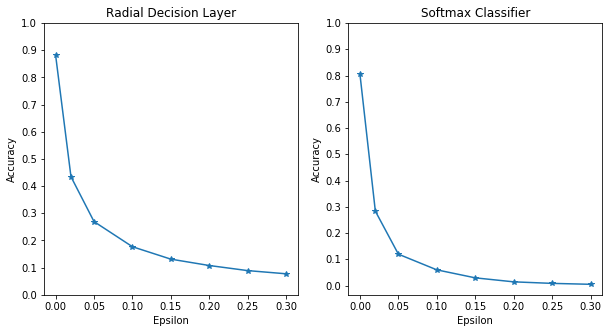

In [12]:
# Plot the accuarcies over the epsilon progression
plt.figure(figsize=(10,5))
for idx, model in enumerate(models):
    plt.subplot(1, 2, idx+1)
    plt.plot(epsilons, model["accuracies"], "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.title(model["name"])

if save_fig:
    plt.savefig("./pics/fgsm_accuracies.png", bbox_inches="tight")

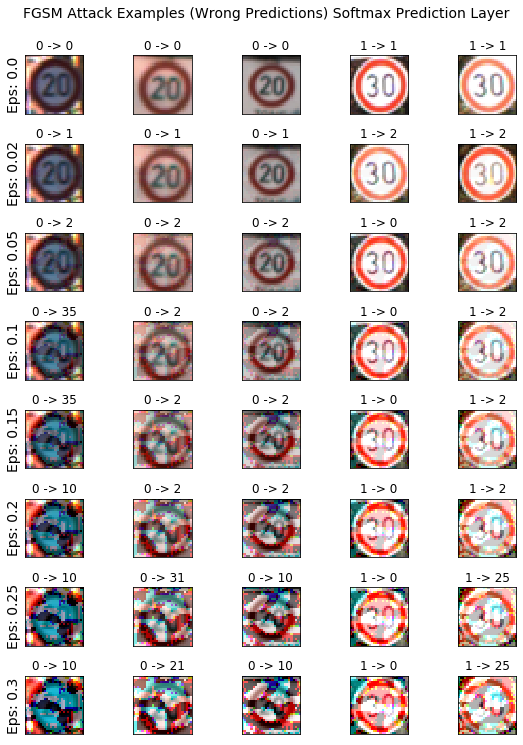

In [13]:
# Plot several examples of adversarial samples at each epsilon
examples = attack_soft["examples"]
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle("FGSM Attack Examples (Wrong Predictions) Softmax Prediction Layer", y=1.03, fontsize=14)
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),(len(examples[0])*i)+j+1)
        
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        #ex1 = np.transpose(ex)   ## Axis:                0, 1, 2 -->  0,1, 2
        ex1 = np.moveaxis(ex,0,2) ## Farbkanal des arrays 3,28,28 --> 28,28,3
        plt.imshow(ex1)   # cmap="gray" --> color

plt.tight_layout()

if save_fig:
    plt.savefig("./pics/fgsm_examples_soft.png", bbox_inches="tight")

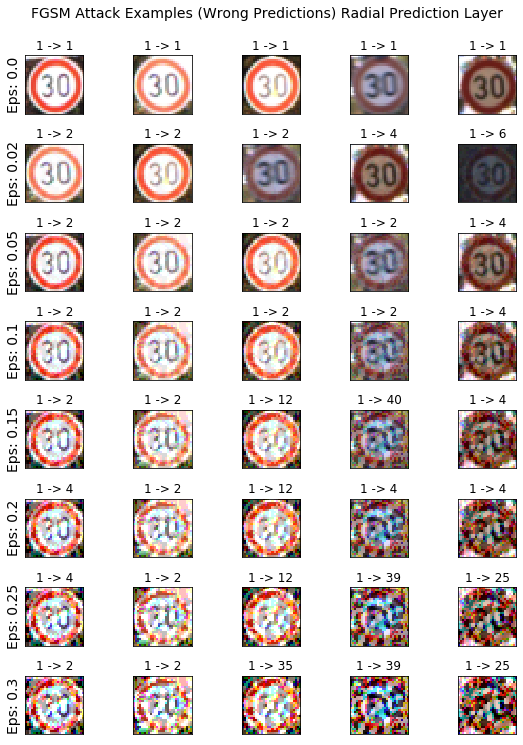

In [14]:
# Plot several examples of adversarial samples at each epsilon
examples = attack_rpl["examples"]
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle("FGSM Attack Examples (Wrong Predictions) Radial Prediction Layer", y=1.03, fontsize=14)
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),(len(examples[0])*i)+j+1)
        
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        #ex1 = np.transpose(ex)   ## Axis:                0, 1, 2 -->  0,1, 2
        ex1 = np.moveaxis(ex,0,2) ## Farbkanal des arrays 3,28,28 --> 28,28,3
        plt.imshow(ex1)   # cmap="gray" --> color

plt.tight_layout()

if save_fig:
    plt.savefig("./pics/fgsm_examples_rpl.png", bbox_inches="tight")